### **PHY654, Machine Learning in Particle Physics, Mid Semester Exam**

September 22, 2024, 13:00 - 15:00, Total marks: 60

This is a coding-based exam, i.e. you will need to write code to answer the questions. One done, send me ONE Python notebook as attachment via email. Do not send me links to notebooks. If links are sent, I will assume that you have modified your code even after the exam is over. You are allowed to use only the following libraries: `NumPy`, `MathPlotLib`, `Pandas`, `Keras`, `TensorFlow`, `Scikit-Learn`, `Seaborn`. Python notebooks should be named as the following: `name_surname_midsem.ipynb`.

Take the file available at https://swmukher.web.cern.ch/swmukher/midsem.csv. This is a simulated dataset of detection of highly energetic particles in an imaging telescope. The telescope produces elliptical shower images of the particles it detected. We want to know if the telescope detected gamma (i.e. photon) (we will call them signal) or hadrons (we will call then background). So, this is a binary classification problem. The following features have been extracted from the shower images of photons and hadrons:

- `fLength`: major axis of ellipse
- `fWidth`: minor axis of ellipse
- `fSize`: log of sum of contents of all pixels
- `fConc`: ratio of sum of two highest pixels over `fSize`
- `fConc1`: ratio of highest pixel over `fSize`
- `fAsym`: distance from highest pixel to center, projected onto major axis
- `fM3Long`: 3rd root of third moment along major axis
- `fM3Trans`: 3rd root of third moment along minor axis
- `fAlpha`: angle of major axis with vector to origin
- `fDist`: distance from origin to center of ellipse

The target variable (i.e. `class`) is `'g'` (gamma) or `'h'` (hadron).

**Questions:**

**1.** Check whether there is any null entry in the dataset or not. \[ **2** \]

In [1]:
url = 'https://swmukher.web.cern.ch/swmukher/midsem.csv' # Locate the dataset

# Import the necessary library
import pandas as pd
df = pd.read_csv(url) # Read the dataset

# Check if there are any null values at all in the entire dataset
has_nulls = df.isnull().values.any()
print("Are there any null entries in the dataset?", has_nulls)

Are there any null entries in the dataset? False


**2.** In the dataset, how many entries correspond to gamma class, and how many entries correspond to hadron class? \[**2**\]

In [4]:
# Count the occurrences of 'g' and 'h' in the 'class' column
class_counts = df['class'].value_counts()

# Display the counts for gamma ('g') and hadron ('h')
print("Number of gamma (g) entries:", class_counts['g'])
print("Number of hadron (h) entries:", class_counts['h'])


Number of gamma (g) entries: 12332
Number of hadron (h) entries: 6688


**3.** On the same canvas, draw two 1D histograms for `fLength`, one for gamma class, one for hadron class. The two histograms should be drawn in different colors and they should be properly labelled so that one can understand which histogram is for hadron and which histogram is for gamma. Use your judgement for number of bins and bin-size. \[**2**\]

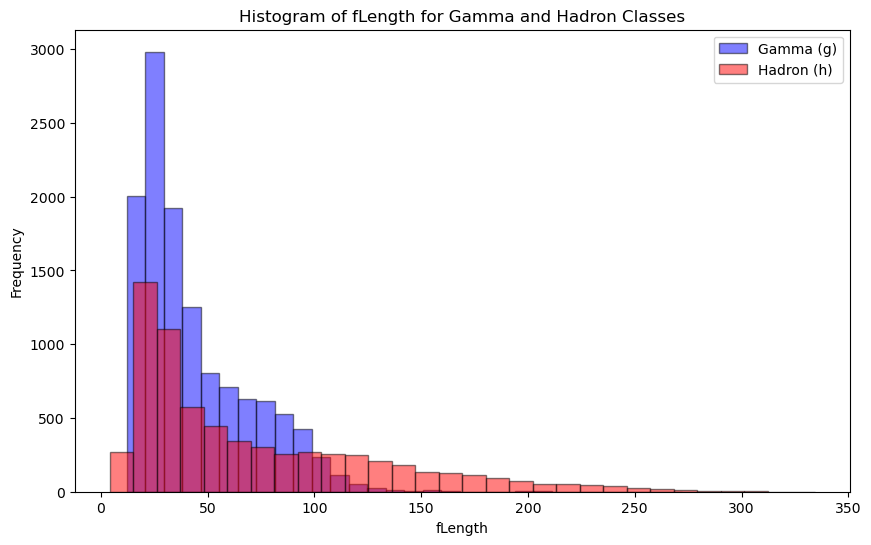

In [7]:
import matplotlib.pyplot as plt

# Separate the data based on the class
gamma_data = df[df['class'] == 'g']['fLength']
hadron_data = df[df['class'] == 'h']['fLength']

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Define bin edges to ensure both histograms use the same bins
bins = 30

# Plot the histogram for gamma class
plt.hist(gamma_data, bins=bins, color='blue', alpha=0.5, label='Gamma (g)', edgecolor='black')

# Plot the histogram for hadron class
plt.hist(hadron_data, bins=bins, color='red', alpha=0.5, label='Hadron (h)', edgecolor='black')

# Add labels and title
plt.xlabel('fLength')
plt.ylabel('Frequency')
plt.title('Histogram of fLength for Gamma and Hadron Classes')

# Add legend
plt.legend()

# Show the plot
plt.show()


**4.** For this question, you do not have to write any code, just look at the plot from the last question, and reply. Let's imagine we wanted to apply a cut on the variable `fLength`, to reject as much background as possible while keeping as much signal as possible. The cut would look like this: `fLength < X`. What can be a reasonable value for $X$? Can you give any reasoning for your choice of $X$? \[Note that you should NOT actually apply this cut in your data.\] \[**5**\]

**Ans:** A reasonable value for $X$ could be around 100, since that is where the hadron distribution starts to dominate over the gamma distribution. This value would allow us to reject a large portion of hadron background while retaining most of the gamma signals.

**5.** Let's say we want to know correlations among the feature variables. Can you draw a correlation matrix for that? Which two features show the highest positive correlation? Which two features show the highest negative correlation? Which two features are almost uncorrelated? \[**7**\]

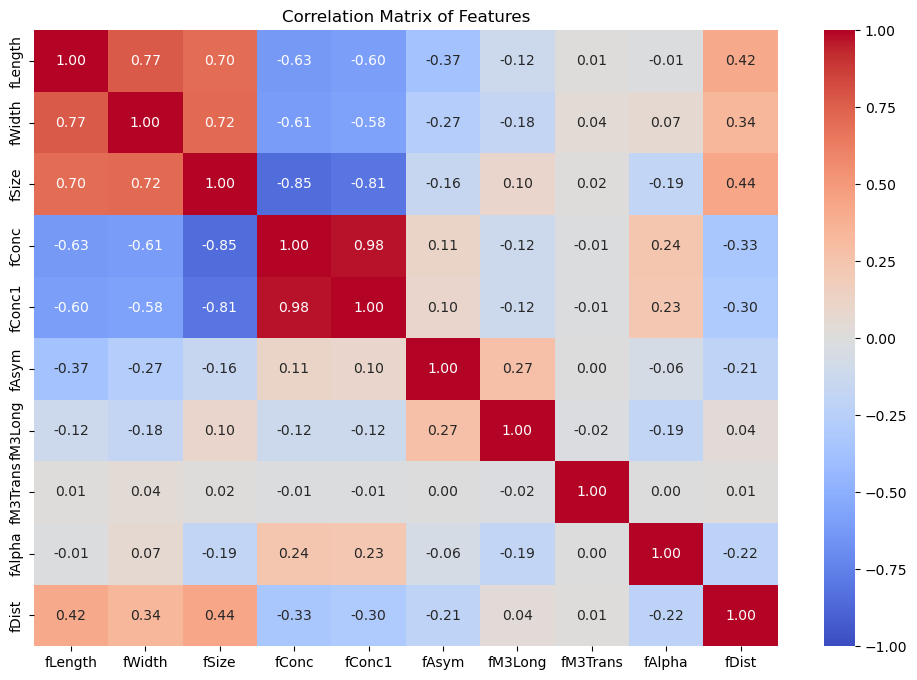

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Drop the 'class' column since it's not a feature, and calculate correlation matrix
correlation_matrix = df.drop(columns=['class', 'Unnamed: 0']).corr()

# Set up the figure
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, cbar=True)

# Add labels and title
plt.title('Correlation Matrix of Features')
plt.show()


From the heatmap of the correlation matrix, it is obvious that:
- variables with the highest positive correlation: `fConc` and `fConc1`,
- variables with the highest negative correlation: `fConc` and `fSize`,
- variables with almost zero correlation: `fAlpha` and `fM3Trans`.
***

**6.** Divide the dataset into three unique parts, training-set, testing-set and validation-set. Use your own judgement about the percentage of events in each of these sets. \[**4**\]

In [16]:
from sklearn.model_selection import train_test_split

# First, split the data into training + validation and testing sets (85% training + validation, 15% testing)
train_val_set, test_set = train_test_split(df, test_size=0.15, random_state=42, stratify=df['class'])

# Then, split the training + validation set into training and validation sets (70% training, 15% validation)
train_set, val_set = train_test_split(train_val_set, test_size=0.1765, random_state=42, stratify=train_val_set['class'])

# Display the sizes of the datasets
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Testing set size: {len(test_set)}")


Training set size: 13313
Validation set size: 2854
Testing set size: 2853


**7.** Use `Keras` to train a neural network for this binary classification task. The neural network must have more than one hidden layer. Use `RMSProp` optimizer with a learning rate of 0.001. We will call it DNN model. If $\displaystyle y_{\text{pred}} > 0.5$, assign the entry to gamma class, otherwise assign it to hadron class. \[**5**\]

In [19]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = df.drop(columns=['class', 'Unnamed: 0'])
y = np.where(df['class'] == 'g', 1, 0)  # Convert 'g' to 1 (gamma), 'h' to 0 (hadron)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the standardized data into training, validation, and test sets
X_train = train_set.drop(columns=['class', 'Unnamed: 0'])
y_train = np.where(train_set['class'] == 'g', 1, 0)

X_val = val_set.drop(columns=['class', 'Unnamed: 0'])
y_val = np.where(val_set['class'] == 'g', 1, 0)

X_test = test_set.drop(columns=['class', 'Unnamed: 0'])
y_test = np.where(test_set['class'] == 'g', 1, 0)

# Standardize the features for each set
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

# Second hidden layer
model.add(Dense(32, activation='relu'))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model using RMSprop optimizer
optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/20


C:\Users\Anant\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7908 - loss: 0.4578 - val_accuracy: 0.8287 - val_loss: 0.3972
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.8465 - loss: 0.3557 - val_accuracy: 0.8416 - val_loss: 0.3857
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.8625 - loss: 0.3371 - val_accuracy: 0.8546 - val_loss: 0.3605
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.8597 - loss: 0.3321 - val_accuracy: 0.8444 - val_loss: 0.3618
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.8606 - loss: 0.3279 - val_accuracy: 0.8574 - val_loss: 0.3516
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.8647 - loss: 0.3229 - val_accuracy: 0.8581 - val_loss: 0.3562
Epoch 7/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.8760 - loss: 0.3092 - val_accuracy: 0.8633 - val_loss: 0.3463
Epoch 8/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8646 - loss: 0.3196 - val_accuracy: 0

**8.** Use `Keras` to train a logistic regression for this binary classification task. Use `RMSProp` optimizer with a learning rate of 0.001. We will call it logistic model. If $y_{\text{pred}} > 0.5$, assign the entry to gamma class, otherwise assign it to hadron class. \[**5**\]

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from sklearn.preprocessing import StandardScaler

# Separate features and labels (assuming you have already done this)
X = df.drop(columns=['class', 'Unnamed: 0'])
y = np.where(df['class'] == 'g', 1, 0)  # Convert 'g' to 1 (gamma), 'h' to 0 (hadron)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the standardized data into training, validation, and test sets (if not already done)
X_train = train_set.drop(columns=['class', 'Unnamed: 0'])
y_train = np.where(train_set['class'] == 'g', 1, 0)

X_val = val_set.drop(columns=['class', 'Unnamed: 0'])
y_val = np.where(val_set['class'] == 'g', 1, 0)

X_test = test_set.drop(columns=['class', 'Unnamed: 0'])
y_test = np.where(test_set['class'] == 'g', 1, 0)

# Standardize the features for each set
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the logistic regression model (single layer)
model_logistic = Sequential()
model_logistic.add(Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid'))

# Compile the model using RMSprop optimizer
optimizer = RMSprop(learning_rate=0.001)
model_logistic.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_logistic = model_logistic.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the test set
test_loss_logistic, test_accuracy_logistic = model_logistic.evaluate(X_test_scaled, y_test)

print(f"Test Accuracy (Logistic Regression): {test_accuracy_logistic:.4f}")


Epoch 1/20


C:\Users\Anant\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5871 - loss: 0.6900 - val_accuracy: 0.7214 - val_loss: 0.5590
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.7346 - loss: 0.5415 - val_accuracy: 0.7498 - val_loss: 0.5057
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.7667 - loss: 0.4882 - val_accuracy: 0.7551 - val_loss: 0.4905
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.7783 - loss: 0.4709 - val_accuracy: 0.7596 - val_loss: 0.4870
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.7817 - loss: 0.4635 - val_accuracy: 0.7621 - val_loss: 0.4858
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.7862 - loss: 0.4664 - val_accuracy: 0.7642 - val_loss: 0.4853
Epoch 7/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.7822 - loss: 0.4637 - val_accuracy: 0.7656 - val_loss: 0.4845
Epoch 8/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.7818 - loss: 0.4701 - val_accuracy:

**9.** For both models that you trained, plot the following metrics as a function of epoch: (a) loss, (b) precision, (c) recall and (d) accuracy. Plot training-metric and validation-metric in same canvas, e.g., for (a), training-loss and validation-loss should be plotted in the same canvas. \[**4**\]

In [25]:
from keras.metrics import Precision, Recall

# Create a new optimizer instance
optimizer_dnn = RMSprop(learning_rate=0.001)

# Recompile the DNN model with the new optimizer and additional metrics
model.compile(optimizer=optimizer_dnn, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the DNN model
history_dnn = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_val_scaled, y_val))


Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8801 - loss: 0.2892 - precision: 0.8775 - recall: 0.9469 - val_accuracy: 0.8619 - val_loss: 0.3383 - val_precision: 0.8655 - val_recall: 0.9319
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.8796 - loss: 0.2826 - precision: 0.8770 - recall: 0.9471 - val_accuracy: 0.8672 - val_loss: 0.3370 - val_precision: 0.8618 - val_recall: 0.9470
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.8837 - loss: 0.2862 - precision: 0.8797 - recall: 0.9515 - val_accuracy: 0.8655 - val_loss: 0.3375 - val_precision: 0.8558 - val_recall: 0.9530
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.8826 - loss: 0.2863 - precision: 0.8776 - recall: 0.9508 - val_accuracy: 0.8637 - val_loss: 0.3388 - val_precision: 0.8714 - val_recall: 0.9265
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.8809 - loss: 0.2791 - precision: 0.8793 - recall: 0.9470 - val_accuracy: 0.8619 - val_

**10.** For both models that you trained, plot confusion matrix based on the test-set. \[**2**\]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step


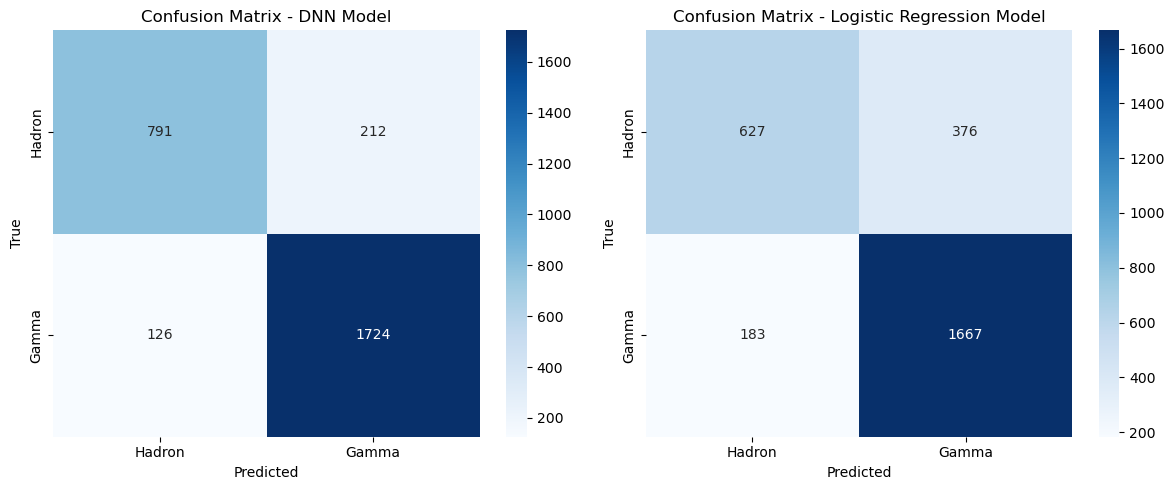

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predictions for the DNN model
y_pred_dnn = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Predictions for the logistic regression model
y_pred_logistic = (model_logistic.predict(X_test_scaled) > 0.5).astype("int32")

# Confusion matrix for DNN model
cm_dnn = confusion_matrix(y_test, y_pred_dnn)

# Confusion matrix for logistic regression model
cm_logistic = confusion_matrix(y_test, y_pred_logistic)

# Plotting confusion matrix for DNN model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Blues', xticklabels=['Hadron', 'Gamma'], yticklabels=['Hadron', 'Gamma'])
plt.title('Confusion Matrix - DNN Model')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plotting confusion matrix for Logistic Regression model
plt.subplot(1, 2, 2)
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=['Hadron', 'Gamma'], yticklabels=['Hadron', 'Gamma'])
plt.title('Confusion Matrix - Logistic Regression Model')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


**11.** In the same canvas, plot the ROC of DNN model and logistic model in different colors, and compare their AUC. The ROC and AUC must be based on the test-set. Looking at ROC and the corresponding AUC, wich model is performing better? Can you give any reasoning for your observation? \[**5**\]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


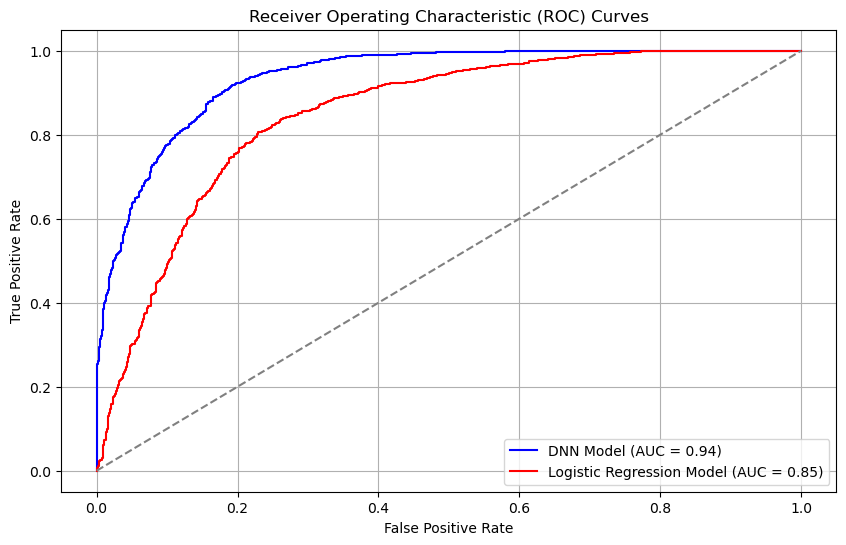

In [31]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the DNN model
y_prob_dnn = model.predict(X_test_scaled).flatten()

# Get predicted probabilities for the logistic regression model
y_prob_logistic = model_logistic.predict(X_test_scaled).flatten()

# Compute ROC curve and AUC for DNN model
fpr_dnn, tpr_dnn, _ = roc_curve(y_test, y_prob_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# Compute ROC curve and AUC for logistic regression model
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_prob_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plotting ROC curves
plt.figure(figsize=(10, 6))

plt.plot(fpr_dnn, tpr_dnn, color='blue', label='DNN Model (AUC = {:.2f})'.format(roc_auc_dnn))
plt.plot(fpr_logistic, tpr_logistic, color='red', label='Logistic Regression Model (AUC = {:.2f})'.format(roc_auc_logistic))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.grid()

# Show the plot
plt.show()


**Ans.** The DNN model has more AUC, so it is performing better than the Logistic Regression model.

#### Reasoning for Observations
- **Complexity of Models:** The DNN can capture more complex relationships in the data compared to logistic regression, which is a linear model. This might lead to better performance, especially in cases where the features are not linearly separable.
- **Capacity:** DNNs have more parameters, allowing them to fit the training data better and potentially generalize better on unseen data, resulting in a higher AUC.

**12.** Obtain accurace score, F1 score, precision, and recall for DNN model and Logistic Regression model, based on the test-set. Looking at these metrics, which model is performing better? \[**4**\]

In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Predict classes for DNN model
y_pred_dnn = (y_prob_dnn > 0.5).astype(int)

# Predict classes for logistic regression model
y_pred_logistic = (y_prob_logistic > 0.5).astype(int)

# Metrics for DNN model
accuracy_dnn = accuracy_score(y_test, y_pred_dnn)
f1_dnn = f1_score(y_test, y_pred_dnn)
precision_dnn = precision_score(y_test, y_pred_dnn)
recall_dnn = recall_score(y_test, y_pred_dnn)

# Metrics for Logistic Regression model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)

# Print results for both models
print("DNN Model Metrics:")
print(f"Accuracy: {accuracy_dnn:.4f}")
print(f"F1 Score: {f1_dnn:.4f}")
print(f"Precision: {precision_dnn:.4f}")
print(f"Recall: {recall_dnn:.4f}")

print("\nLogistic Regression Model Metrics:")
print(f"Accuracy: {accuracy_logistic:.4f}")
print(f"F1 Score: {f1_logistic:.4f}")
print(f"Precision: {precision_logistic:.4f}")
print(f"Recall: {recall_logistic:.4f}")


DNN Model Metrics:
Accuracy: 0.8815
F1 Score: 0.9107
Precision: 0.8905
Recall: 0.9319

Logistic Regression Model Metrics:
Accuracy: 0.8041
F1 Score: 0.8564
Precision: 0.8160
Recall: 0.9011


**Ans.** Obviously, the DNN model is performing better than the Logistic Regression model.

**13.** Plot 1D histogram of $y_{\text{pred}}$ for gamma class and hadron class for DNN and Logistic Regression model. That will be four histograms on the same canvas. Make sure to draw them using separate, understandable colors, and label them properly. \[Remember that $y_{\text{pred}}$ is the output of the models, it is supposed to be a probability, i.e., a number between 0 and 1.\] \[**5**\]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step


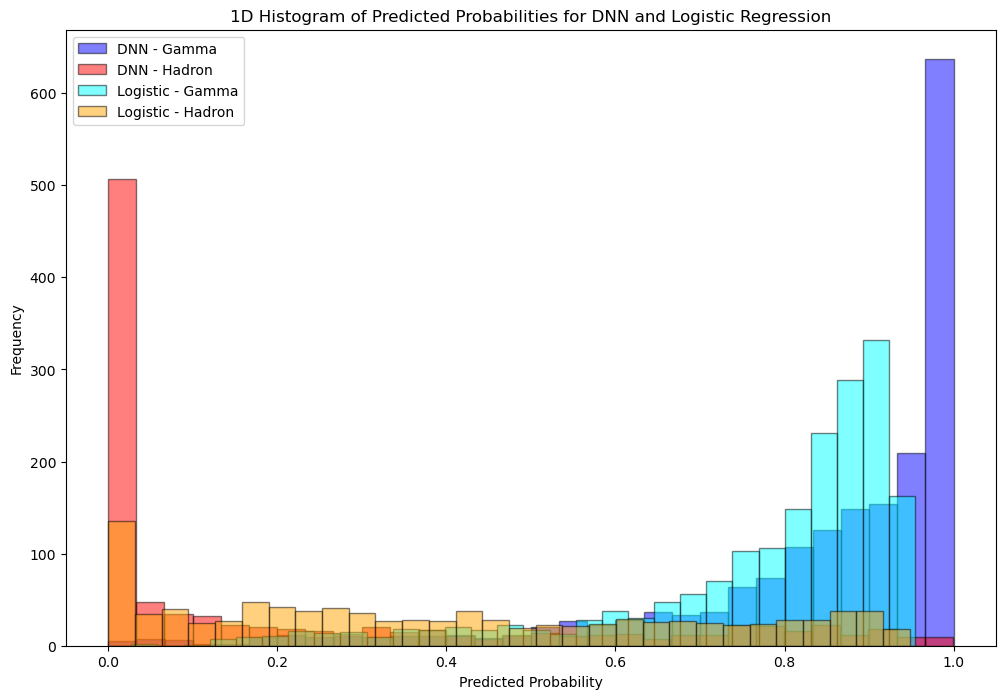

In [39]:
# For DNN model
y_prob_dnn = model.predict(X_test_scaled).flatten()

# For Logistic Regression model
y_prob_logistic = model_logistic.predict(X_test_scaled).flatten()

# Separate probabilities for gamma (1) and hadron (0) for DNN
gamma_prob_dnn = y_prob_dnn[y_test == 1]
hadron_prob_dnn = y_prob_dnn[y_test == 0]

# Separate probabilities for gamma (1) and hadron (0) for Logistic Regression
gamma_prob_logistic = y_prob_logistic[y_test == 1]
hadron_prob_logistic = y_prob_logistic[y_test == 0]

import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(12, 8))

# Histogram for DNN model
plt.hist(gamma_prob_dnn, bins=30, color='blue', alpha=0.5, label='DNN - Gamma', edgecolor='black')
plt.hist(hadron_prob_dnn, bins=30, color='red', alpha=0.5, label='DNN - Hadron', edgecolor='black')

# Histogram for Logistic Regression model
plt.hist(gamma_prob_logistic, bins=30, color='cyan', alpha=0.5, label='Logistic - Gamma', edgecolor='black')
plt.hist(hadron_prob_logistic, bins=30, color='orange', alpha=0.5, label='Logistic - Hadron', edgecolor='black')

# Add labels and title
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('1D Histogram of Predicted Probabilities for DNN and Logistic Regression')
plt.legend()

# Show the plot
plt.show()


**14.** Let's say we want to move the classification threshold from $y_{\text{pred}} > 0.5$ to $y_{\text{pred}} > 0.8$, i.e., if $y_{\text{pred}} > 0.8$, assign the entry to gamma class, otherwise assign it to hadron class. You have to do this without retraining the models. With this new threshold, what will be the precision for DNN model and Logistic Regression model, based on the test-set? What do you observe here? Is the precision better than before or worse than before? Can you explain your observation? \[**8**\]

In [42]:
# Apply the new threshold
threshold = 0.8

# Predictions based on the new threshold
y_pred_dnn_new = (y_prob_dnn > threshold).astype(int)
y_pred_logistic_new = (y_prob_logistic > threshold).astype(int)

from sklearn.metrics import precision_score

# Calculate precision for DNN model
precision_dnn_new = precision_score(y_test, y_pred_dnn_new)

# Calculate precision for Logistic Regression model
precision_logistic_new = precision_score(y_test, y_pred_logistic_new)

print(f"Precision for DNN model with threshold 0.8: {precision_dnn_new:.4f}")
print(f"Precision for Logistic Regression model with threshold 0.8: {precision_logistic_new:.4f}")



Precision for DNN model with threshold 0.8: 0.9407
Precision for Logistic Regression model with threshold 0.8: 0.8911


If anything is unclear, ask.